In [2]:
import sys
from torchsummary import summary
import ast
import torch
import random
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
sys.path.append("../../")
sys.path.append("../")
####### Dataset ############
from data_processor import DataProcessor
######## Search space #########
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results, get_generation_dfs
######## Training ###############
from trainer import Trainer, TrainerDistillation
from utils.train_cfg import get_cfg, show_cfg
###################################################
random_seed = 1
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from datetime import datetime
import itertools
import pandas as pd
import json
from io import StringIO
from coolname import generate_slug
from sklearn.metrics import accuracy_score
import torch.multiprocessing as mp

# Load dataset

In [3]:
def load_dataset_metadata(dataset_path):
    with open(os.path.join(dataset_path, 'metadata'), "r") as f:
        metadata = json.load(f)
    return metadata
# load dataset from file
def load_datasets(data_path, truncate):
    data_path = '../../datasets/'+data_path
    train_x = np.load(os.path.join(data_path,'train_x.npy'))
    train_y = np.load(os.path.join(data_path,'train_y.npy'))
    valid_x = np.load(os.path.join(data_path,'valid_x.npy'))
    valid_y = np.load(os.path.join(data_path,'valid_y.npy'))
    test_x = np.load(os.path.join(data_path,'test_x.npy'))
    metadata = load_dataset_metadata(data_path)

    if truncate:
        train_x = train_x[:64]
        train_y = train_y[:64]
        valid_x = valid_x[:64]
        valid_y = valid_y[:64]
        test_x = test_x[:64]

    return (train_x, train_y), \
           (valid_x, valid_y), \
           (test_x), metadata

def validation(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 4. Calculate Accuracy
    accuracy = correct / total
    print('Accuracy on the test set: {:.2f}%'.format(accuracy * 100))

In [4]:
Dataset="Gutenberg"
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = load_datasets(Dataset, truncate=False)
test_y = np.load(os.path.join('../../datasets/'+Dataset,'test_y.npy'))
metadata["select_augment"]=False
data_processor = DataProcessor(train_x[:], train_y[:], valid_x, valid_y, test_x, metadata)
train_loader, valid_loader, test_loader = data_processor.process()


metadata

/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.2.0/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


{'input_shape': [45000, 1, 27, 18],
 'codename': 'Gutenberg',
 'benchmark': 40.98,
 'num_classes': 6,
 'select_augment': False,
 'train_config_path': 'configs/train/augmentations_adam.yaml'}

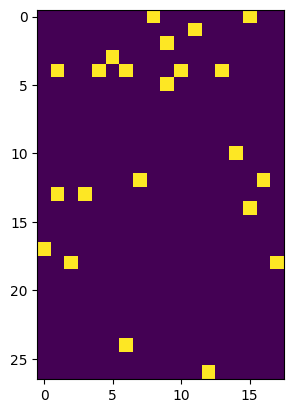

In [5]:
img=next(iter(train_loader))[0][0]
img=img.numpy().transpose(1, 2, 0)
plt.imshow(img)

# Load search space and population

In [6]:
rg=regnet_space=RegNet(metadata,
                    W0=[16, 120, 8],
                    WA=[16, 64, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,8,8], 
                    base_config=f"../configs/search_space/config.yaml")

In [8]:
folder=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{Dataset}"
models, chromosomes, configs=rg.load_generation(folder)

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Gutenberg/asparagus_doberman/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Gutenberg/icy_muskox/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Gutenberg/quantum_vole/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Gutenberg/blazing_jaguarundi/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Gutenberg/miniature_chinchilla/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Gutenberg/steel_teal/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Gutenberg/artichoke_tarsier/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Gutenberg/charcoal_dormouse/config.yaml
Loading model: /home/woody/iwb3/iwb302

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
#model_best, info_best, _= regnet.load_model("output/test_regnet_cifar100/RegNetY800MF", weights_file="output/test_regnet_cifar100/RegNetY800MF/student_best")
#summary(model_best, (3,32,32))

In [ ]:
#rg.create_widths_plot(chromosomes)

# Train teacher (regnet)

In [9]:
#

# Train student

In [10]:
from distillation.config import get_cfg

In [ ]:
# Set seed for Python random module
import random
import numpy as np
import time
from IPython.display import clear_output

def train_model(student,model_student, teachers=None, configs=None):
    #try:
        clear_output(wait=True)
        cfg_dist=get_cfg()

        student_from_nas=True
        teacher_from_nas=True

        cfg_path="../configs/distillation/cifar100/parent_to_offspring_parentsKD.yaml"
        
        #cfg_path="../configs/distillation/cifar100/vainilla_generation.yaml"
        #cfg_path="../configs/cifar100/resnet32x4_ind1.yaml"
        cfg_dist.merge_from_file(cfg_path)
        #####################################
        cfg_dist.EXPERIMENT.LOGIT_STAND = True
        kd_weight = [9]
        base_temp = 3
        cfg_dist.SOLVER.CUDA = True
        cfg_dist.LOG.WANDB = False
        
        #if cfg_dist.DISTILLER.TYPE!="NONE":
            

        if cfg_dist.EXPERIMENT.LOGIT_STAND:
                if cfg_dist.DISTILLER.TYPE == 'KD':
                    cfg_dist.KD.LOSS.KD_WEIGHT = kd_weight[0]
                    cfg_dist.KD.TEMPERATURE = base_temp
                elif cfg_dist.DISTILLER.TYPE == 'ParentsKD':
                    cfg_dist.KD.LOSS.KD_WEIGHT = kd_weight
                    cfg_dist.KD.TEMPERATURE = base_temp
                    cfg_dist.KD.LOSS.KD_EPOCHS= 2
                    cfg_dist.KD.LOSS.KD_REDUCTION=True
                elif cfg_dist.DISTILLER.TYPE == 'DKD':
                    cfg_dist.DKD.ALPHA = cfg_dist.DKD.ALPHA * kd_weight[0]
                    cfg_dist.DKD.BETA = cfg_dist.DKD.ALPHA * kd_weight[0]
                    cfg_dist.KD.TEMPERATURE = base_temp
                    cfg_dist.DKD.WARMUP=1
                elif cfg_dist.DISTILLER.TYPE == 'MLKD':
                    cfg_dist.KD.LOSS.KD_WEIGHT = kd_weight[0]
                    cfg_dist.KD.TEMPERATURE = base_temp
            
        cfg_dist.freeze()
        show_cfg(cfg_dist)
        time.sleep(2)
        ##############################################

        if teacher_from_nas:
            if cfg_dist.DISTILLER.TYPE=="ParentsKD":
                for teacher_name in teachers.keys():
                    print("Teacher name/parent: ", teacher_name)
                print("Student :",student)
                time.sleep(2)
                experiment_name = f"parent_{student}_{"_".join(list(teachers.keys()))}_{cfg_dist.DISTILLER.TYPE}_{"_".join(map(str,kd_weight))}_{base_temp}_lr05"
            else:    
                experiment_name = f"parent_{student}_{"_".join(list(teachers.keys()))}_{cfg_dist.DISTILLER.TYPE}_{"_".join(map(str,kd_weight))}_{base_temp}_lr05"
                teacher_name=list(teachers.keys())[0]
                print("Teacher name/parent: ", teacher_name)
                print("Student :",student)
                time.sleep(2)
        else:
            if cfg_dist.DISTILLER.TYPE=="NONE":
                experiment_name = f"{student}"
            else:
                experiment_name = f"parent_{student}_{"_".join(list(teachers.keys()))}_{"_".join(map(str,kd_weight))}"



        tags = cfg_dist.EXPERIMENT.TAG.split(",")
        experiment_name = os.path.join(cfg_dist.EXPERIMENT.PROJECT, experiment_name)
        print(experiment_name)
        #############################################
        if cfg_dist.DISTILLER.TYPE == 'MLKD':
            train_loader, val_loader, num_data, num_classes = get_dataset_strong(cfg_dist)
        else:
            train_loader, val_loader, num_data, num_classes = get_dataset(cfg_dist)

        print(cfg_dist.DISTILLER.TYPE)
        ############################################
        if cfg_dist.DISTILLER.TYPE == "NONE":
            distiller = distiller_dict[cfg_dist.DISTILLER.TYPE](model_student)
        else:
            if not teacher_from_nas:
                if cfg_dist.DISTILLER.TYPE !="ParentsKD":
                    print(log_msg("Loading teacher model", "INFO"))
                    net, pretrain_model_path = cifar_model_dict[cfg_dist.DISTILLER.TEACHER]
                    assert (
                        pretrain_model_path is not None
                    ), "no pretrain model for teacher {}".format(cfg_dist.DISTILLER.TEACHER)
                    model_teacher = net(num_classes=num_classes)
                    model_teacher.load_state_dict(load_checkpoint(pretrain_model_path)["model"])
                    model_teacher.to(device)
                else:
                    model_teacher=[]
                    for teacher_name in teachers.keys():
                        print(teacher_name)
                        print(log_msg("Loading teacher model", "INFO"))
                        time.sleep(2)
                        net, pretrain_model_path = cifar_model_dict[teacher_name]
                        assert (
                            pretrain_model_path is not None
                        ), "no pretrain model for teacher {}".format(teacher_name)
                        model = net(num_classes=num_classes)
                        model.load_state_dict(load_checkpoint(pretrain_model_path)["model"])
                        model.to(device)
                        model_teacher.append(model)

            else:
                input_tensor=next(iter(train_loader))[0]
                model_teacher=[]
                for teacher_name, teacher_model in teachers.items():
                    print(teacher_name)
                    time.sleep(2)                     
                    model_teacher.append(teacher_model)
                if cfg_dist.DISTILLER.TYPE != "ParentsKD":
                    model_teacher=model_teacher[0]


            if cfg_dist.DISTILLER.TYPE == "CRD":
                distiller = distiller_dict[cfg_dist.DISTILLER.TYPE](
                    model_student, model_teacher, cfg_dist, num_data
                )
            else:
                distiller = distiller_dict[cfg_dist.DISTILLER.TYPE](
                    model_student, model_teacher, cfg_dist
                )
        #########################################################
        if cfg_dist.SOLVER.CUDA:
            distiller = torch.nn.DataParallel(distiller.cuda())
        else:
            distiller = torch.nn.DataParallel(distiller)
        ####################################################
        trainer = trainer_dict[cfg_dist.SOLVER.TRAINER](
            experiment_name, distiller, train_loader, val_loader, cfg_dist
        )

        clear_output(wait=True)
        trainer.train(resume=False)
        
        ##################################################
        if configs is not None:
            output_file_path = f"output/{experiment_name}/config_model.yaml"
            with open(output_file_path, "w") as f:
              f.write(configs[student].dump()) 

        output_file_path = f"output/{experiment_name}/config_dist.yaml"
        with open(output_file_path, "w") as f:
          f.write(cfg_dist.dump()) 
        ################## Save configs ################
        print(f"Error with model {student}")
